In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import geopandas as gp
df = pd.read_csv('data-wrangling-and-validation/data/lesson-programmatic/patient-data-anonymisation-exercise.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53346 entries, 0 to 53345
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PATIENT_ID         53346 non-null  object 
 1   START              53346 non-null  object 
 2   STOP               53346 non-null  object 
 3   ENCOUNTERCLASS     53346 non-null  object 
 4   DESCRIPTION        53346 non-null  object 
 5   TOTAL_CLAIM_COST   53346 non-null  float64
 6   PAYER_COVERAGE     53346 non-null  float64
 7   REASONDESCRIPTION  13777 non-null  object 
 8   BIRTHDATE          53346 non-null  object 
 9   DEATHDATE          14287 non-null  object 
 10  SSN                53346 non-null  object 
 11  DRIVERS            49285 non-null  object 
 12  PASSPORT           46965 non-null  object 
 13  FIRST              53346 non-null  object 
 14  LAST               53346 non-null  object 
 15  MAIDEN             16597 non-null  object 
 16  MARITAL            436

In [3]:
gdf = gp.GeoDataFrame(df,crs = 'EPSG:4326',geometry = gp.points_from_xy(df.LON, df.LAT))

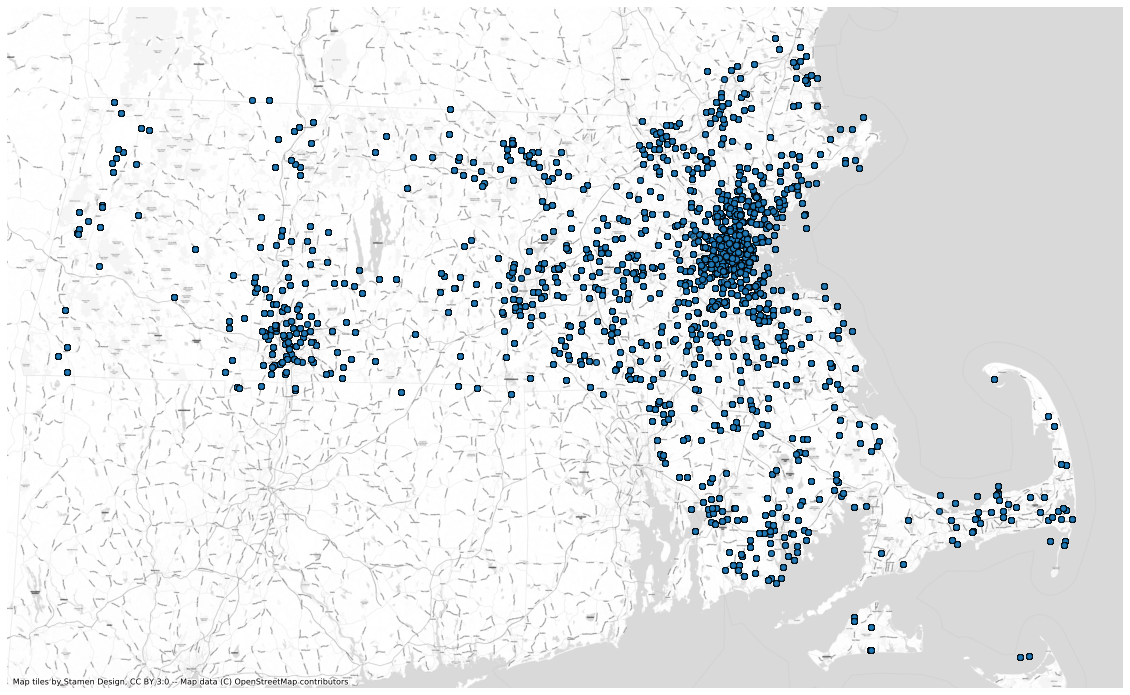

In [4]:
import contextily as ctx
#reproject
gdf = gdf.to_crs(epsg = 3857)
ax = gdf.plot(figsize = (20,20), alpha = 0.5, edgecolor = 'k')
ctx.add_basemap(ax = ax, source = ctx.providers.Stamen.TonerLite, zoom = 12)
ax.set_axis_off()

In [5]:
suppression = ["SSN", "DRIVERS", "PASSPORT", "FIRST", "LAST", "MAIDEN", "ADDRESS", "ZIP"]
df.drop(suppression, axis = 1, inplace = True)

In [6]:
import uuid
str(uuid.uuid4())

'44d2db4a-b99e-4502-9cb3-d57b12e7eea2'

In [7]:
sigma = 0.001
mu = 1
np.random.normal(mu, sigma)

1.0016063685222494

In [8]:
from collections import defaultdict
class Pseudonymise:
    def __init__(self, sigma = 0.001):
        self.sigma = sigma
        self.mu = 0
        self.pp = defaultdict(lambda : {'uuid' : str(uuid.uuid4()),
                                       'lat' : np.random.normal(self.mu, self.sigma),
                                       'lon' : np.random.normal(self.mu, self.sigma)
                                       })
    def create_data(self, identities):
        """
        Pour chaque identité unique produire un UUID unique, et un gaussien randonisé 'LAT' et 'LON'.
        Parameters
        ----------
        identities:liste des chaines de caractères
        
        Returns
        -------
        dict 
            Chaque entrée de dict contient un enregistrement contenant un "uuid" et un modificateur pour "lat" et "lon"
        """
        for _id in identities:
            self.pp[_id]
        return self.pp
    def redact(self,row):
        """
        Pour une ligne donnée dans un dataframe, retourner la version pseudonymisée de "PATIENT_ID", "LAT", "LON".
            Parameters:
            row : Ligne de la trame de données
            row : DataFrame tranche de ligne
            """
        return [
            self.pp[row['PATIENT_ID']]['uuid'],
            row['LAT'] + self.pp[row['PATIENT_ID']]['lat'],
            row['LON'] + self.pp[row['PATIENT_ID']]['lon'],
        ]
p = Pseudonymise()
pp_data = p.create_data(df['PATIENT_ID'])
fields = ['PATIENT_ID', 'LAT', 'LON']
df[fields] = df[fields].apply(p.redact, axis = 1, result_type = 'expand')

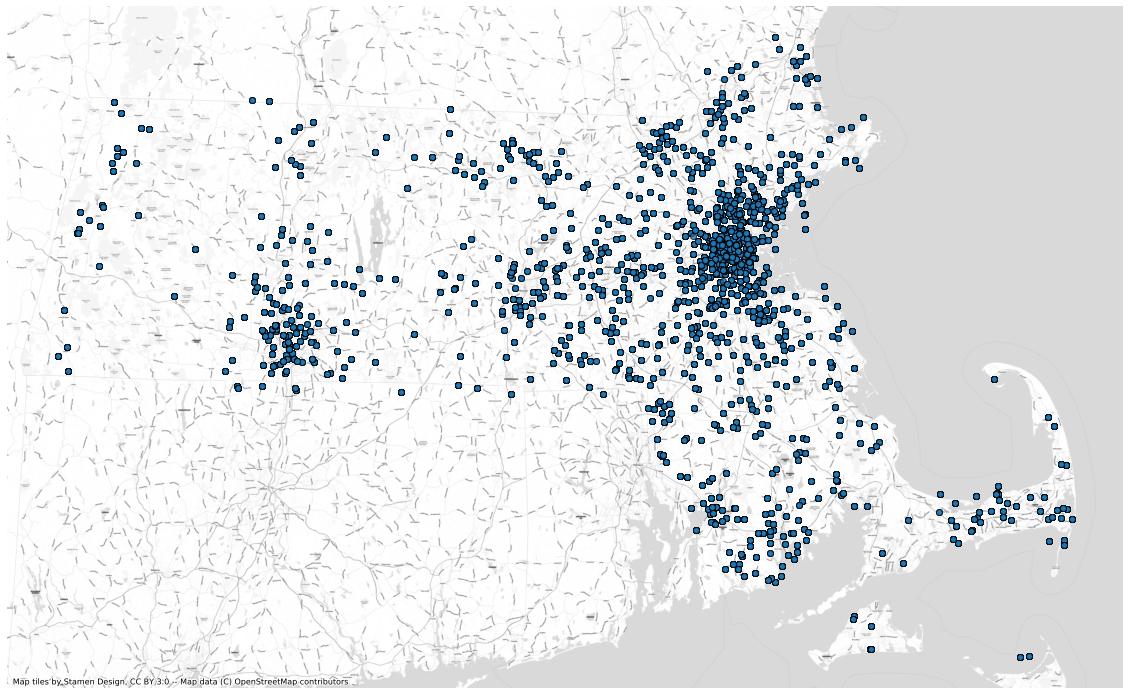

In [9]:
gdf = gp.GeoDataFrame(df, crs = "EPSG:4326", geometry = gp.points_from_xy(df.LON, df.LAT))
gdf = gdf.to_crs(epsg = 3857)
ax = gdf.plot(figsize = (20,20), alpha = 0.5, edgecolor = 'k')
ctx.add_basemap(ax = ax, source =ctx.providers.Stamen.TonerLite, zoom = 12)
ax.set_axis_off()

### Aggregation

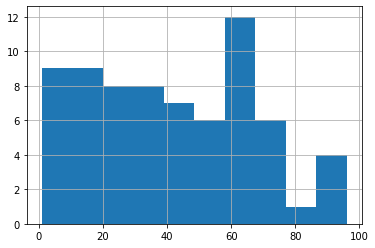

In [10]:
df = df.copy()
for c in ["START","STOP", "BIRTHDATE", "DEATHDATE"]:
    df[c]= df[c].apply(lambda x : pd.to_datetime(x, errors = "coerce", dayfirst = True).date())
df = df[df.STOP == df.DEATHDATE]
df.sort_values(by = "STOP", inplace = True)
df.drop_duplicates(subset = "PATIENT_ID", keep = "last", inplace = True)
df["DEATHAGE"] = df.DEATHDATE.apply(lambda x : x.year) - df.BIRTHDATE.apply(lambda x : x.year)
df["DEATHAGE"].hist(bins = 10)